In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

In [2]:
def plot_map(fig, ax, x, y, z, cmapmc):
    if cmapmc == None:
        pass
    else:
        p = ax.pcolorfast(x, y, z, cmap=cmapmc, vmin=-1600, vmax=1000)
    CS = ax.contour(x, y, z, levels = np.arange(-500, 0, 20), colors='k', linestyle='-', alpha=0.5)
    for line in CS.collections:
        if line.get_linestyle() == [(None, None)]:
            print("Solid Line")
        else:
            line.set_linestyle([(None, None)])
            line.set_color('k')
    ax.clabel(CS, fmt='%1.1f')
    n=4
    ax.legend(loc=2, fontsize=20)
    ax.set_xlim([-141, -136])
    ax.set_ylim([69.5, 70.5])
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    ax.set_ylabel('latitude [$^o$]', fontsize=20)
    ax.set_xlabel('longitude [$^o$]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    fig.tight_layout()
    return fig, ax

In [3]:
def get_coords(dirname):
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = slice(1,-1,None), slice(1,-1,None)

    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        nav_lat = dsT.variables['nav_lat'][y, x]
        nav_lon = dsT.variables['nav_lon'][y, x]

    return nav_lat, nav_lon

In [4]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

dist_s = data_south['dist'][0,:]
lat_s = data_south['latx'][0,:]
lon_s = data_south['lonx'][0,:]

dist_n = data_north['dist'][0,:]
lat_n = data_north['latx'][0,:]
lon_n = data_north['lonx'][0,:]

In [45]:
def get_closest_coords(lon, lat, nav_lon, nav_lat):

    j_full = np.full(len(lon), np.nan)
    i_full = np.full_like(j_full, np.nan)
    nav_lon_full = np.full_like(j_full, np.nan)
    nav_lat_full = np.full_like(j_full, np.nan)

    for n in range(len(lon)):

        j, i = geo_tools.find_closest_model_point(lon[n], lat[n], nav_lon, nav_lat, grid='MCKNZ', land_mask=None,
                                                  tols={'MCKNZ': {'tol_lon': 0.02, 'tol_lat': 0.02}})

        j_full[n] = j
        i_full[n] = i
        nav_lon_full[n] = nav_lon[j, i]
        nav_lat_full[n] = nav_lat[j, i]

    return j_full, i_full, nav_lon_full, nav_lat_full

In [46]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_muscl_partial/'
nav_lat, nav_lon = get_coords(dirname)

In [47]:
j_s, i_s, nav_lon_s, nav_lat_s = get_closest_coords(lon_s, lat_s, nav_lon, nav_lat)
j_n, i_n, nav_lon_n, nav_lat_n = get_closest_coords(lon_n, lat_n, nav_lon, nav_lat)

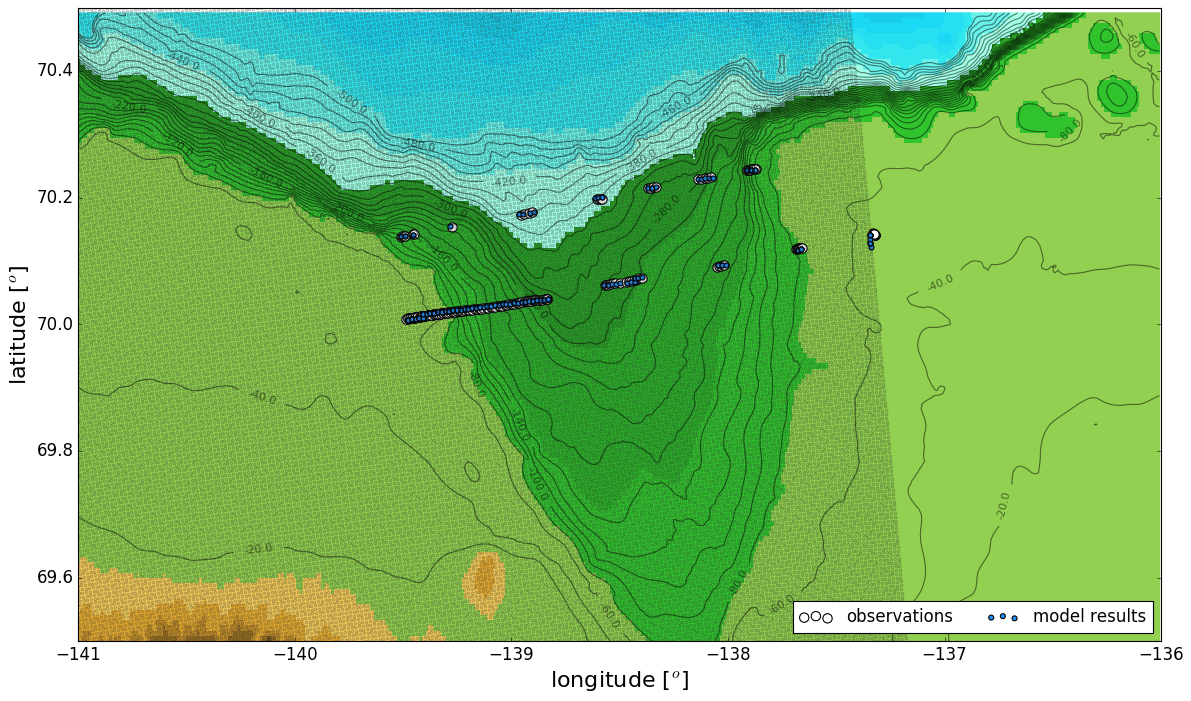

In [48]:
x, y, z = functions_plot.def_regionG(xl=-141, xr=-136, yb=69.5, yt=70.5)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

fig, ax = plot_map(fig, ax, x, y, z, cmapmc)

ax.scatter(lon_s, lat_s, c='w', s=70, edgecolors='k')
ax.scatter(lon_n, lat_n, c='w', s=70, edgecolors='k', label='observations')

ax.scatter(nav_lon_s, nav_lat_s, s=20, edgecolors='k', c='dodgerblue')
ax.scatter(nav_lon_n, nav_lat_n, s=20, edgecolors='k', c='dodgerblue', label='model results')

ax.scatter(nav_lon, nav_lat, s=5, edgecolors='k', c='gray', alpha=0.2)

ax.legend(ncol=2, loc=4, fontsize=15)

https://stackoverflow.com/questions/23301231/how-to-append-masked-arrays

In [49]:
def get_vars(dirname, j, i, time_start, time_end, var):
        
    fname = "1_MCKNZ_1h_20170101_201701*"
    y,x = int(j+1), int(i+1)
    
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
            
    with scDataset(filesT) as dsT:
        deptht = dsT.variables['deptht'][:]
        var0 = dsT.variables[var][time_start:time_end, :, y, x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0, :, y, x]
        
    tmask = np.tile(tmask0, (len(var0), 1))  
    var = np.ma.array(var0, mask=1 - tmask)
    
    var_mean = np.mean(var, axis=0)
    
    return var, var_mean, deptht, tmask

In [50]:
def masked_stack(tup):
    return np.ma.masked_array(np.vstack(tup), mask=np.vstack([arr.mask for arr in tup]))

In [51]:
def get_vars_stations(dirname, j_full, i_full, time_start, time_end, var_name):
    
    for n in range(len(j_full)):

        j, i = int(j_full[n]), int(i_full[n])
        
        if var_name == 'salinity':
            var, var_mean, deptht, tmask = get_vars(dirname, j, i, time_start, time_end, 'vosaline')
        elif var_name == 'temperature':
            var, var_mean, deptht, tmask = get_vars(dirname, j, i, time_start, time_end, 'votemper')
            
        if n == 0:
            var_mean_stations = var_mean
        else:
            var_mean_stations = masked_stack((var_mean_stations, var_mean))
            
    var_mean_stations = np.transpose(var_mean_stations)
        
    return var_mean_stations, deptht

In [ ]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_muscl_partial/'
time_start, time_end = 24*3, 24*4

salt_mean_stations_n, deptht = get_vars_stations(dirname, j_n, i_n, time_start, time_end, 'salinity')
salt_mean_stations_s, deptht = get_vars_stations(dirname, j_s, i_s, time_start, time_end, 'salinity')

In [54]:
temp_mean_stations_n, deptht = get_vars_stations(dirname, j_n, i_n, time_start, time_end, 'temperature')
temp_mean_stations_s, deptht = get_vars_stations(dirname, j_s, i_s, time_start, time_end, 'temperature')

In [55]:
temp_mean_stations_n.shape, temp_mean_stations_s.shape

((80, 35), (80, 222))

In [56]:
def plot_crosscanyon_panels(fig, ax, dist, dep, var, num, vmin, vmax, var_name, transect_name):
    cmap = plt.get_cmap(cmapIAM)
    cmap.set_bad('silver')
    
    if num == None:
        p = ax.pcolormesh(var, cmap=cmap, vmin=vmin, vmax=vmax)#dist, dep, 
        #ax.set_xlim([dist.min(), dist.max()])
        ttl_add = ''
    else:
        f = interpolate.interp1d(dist, var)
        dist_new = np.linspace(dist[0], dist[-1], num=num)
        var_new = f(dist_new)
        var_new = ma.masked_invalid(var_new)
        p = ax.pcolormesh(dist_new, dep, var_new, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([dist_new.min(), dist_new.max()])
        ttl_add = ' (interpolated)'
        
    #ax.set_ylim([np.nanmax(dep), np.nanmin(dep)])
    ax.set_xlabel('distance', fontsize=20)
    ax.set_ylabel('depth [m]', fontsize=20)
    fig.colorbar(p, ax=ax)
    ax.set_title(transect_name+' '+var_name + ttl_add, fontsize=20)
    return ax

In [58]:
salt_mean_stations_s.shape

(80, 222)

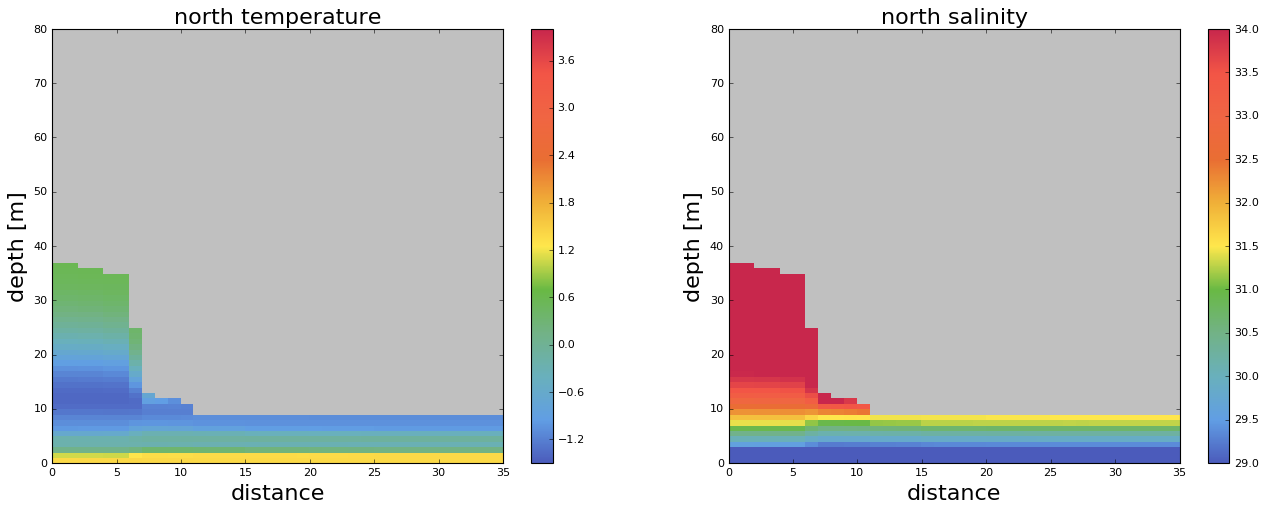

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_crosscanyon_panels(fig, ax1, dist_n, deptht, temp_mean_stations_n, None, -1.5, 4, 'temperature', 'north')
ax2 = plot_crosscanyon_panels(fig, ax2, dist_n, deptht, salt_mean_stations_n, None, 29, 34, 'salinity', 'north')

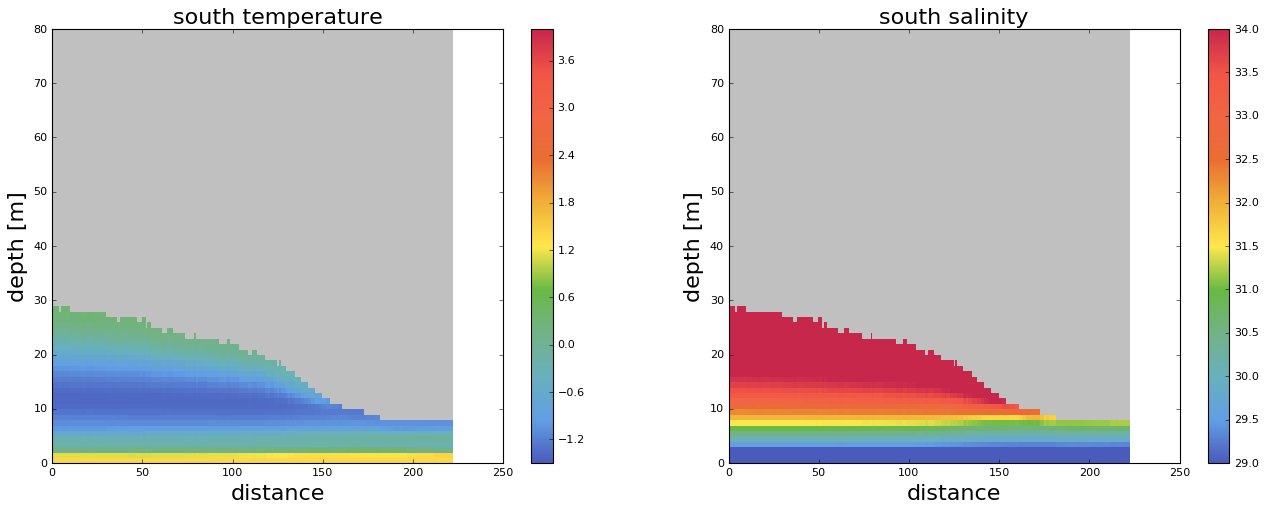

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1 = plot_crosscanyon_panels(fig, ax1, dist_n, deptht, temp_mean_stations_s, None, -1.5, 4, 'temperature', 'south')
ax2 = plot_crosscanyon_panels(fig, ax2, dist_n, deptht, salt_mean_stations_s, None, 29, 34, 'salinity', 'south')